# Load data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
nltk.download('punkt')
nltk.download('popular')
nltk.download('vader_lexicon')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read in data
df = pd.read_csv('/content/drive/MyDrive/Dataset /Natural Language Processing/Sentiment Analysis/amazon_reviews_us_Jewelry_v1_00.tsv', header = 0, sep = '\t', error_bad_lines = False)
print(df.shape)
df = df.head(500)
print(df.shape)

#Because dataset is large so I just wanna pick a small data with 500 sample to experiment Pre-trained Model

In [15]:
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,50423057,R135Q3VZ4DQN5N,B00JWXFDMG,657335467,Everbling Purple and Clear Briolette Drop Swar...,Jewelry,5,0.0,0.0,N,Y,Beauties!,so beautiful even tho clearly not high end ......,2015-08-31
1,US,11262325,R2N0QQ6R4T7YRY,B00W5T1H9W,26030170,925 Sterling Silver Finish 6ct Simulated Diamo...,Jewelry,5,0.0,0.0,N,N,Great product.,"Great product.. I got this set for my mother, ...",2015-08-31
2,US,27541121,R3N5JE5Y4T6W5M,B00M2L6KFY,697845240,"Sterling Silver Circle ""Friends Forever"" Infin...",Jewelry,5,0.0,0.0,N,Y,Exactly as pictured and my daughter's friend l...,Exactly as pictured and my daughter's friend l...,2015-08-31
3,US,5350721,R2I150CX5IVY9Q,B0006SW2WU,569859289,Surgical Stainless Steel Domed 9mm Fishbone Ri...,Jewelry,5,0.0,0.0,N,Y,Five Stars,Love it. Fits great. Super comfortable and nea...,2015-08-31
4,US,24484424,R1RM9ICOOA9MQ3,B009YPDW70,332947422,"Sterling Silver Family Pendant Necklace, 18""",Jewelry,5,0.0,0.0,N,Y,... a Mother's Day gift for my Mom and she lov...,Got this as a Mother's Day gift for my Mom and...,2015-08-31


## Exploratory Data Analysis 

In [65]:
df = df[['star_rating','review_body']]

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   star_rating  500 non-null    object
 1   review_body  500 non-null    object
dtypes: object(2)
memory usage: 7.9+ KB


In [19]:
df.isnull().sum()

star_rating    0
review_body    0
dtype: int64

In [67]:
df=df.dropna()
df = df.reset_index(drop=True)

In [68]:
#convert the star_rating column to int
df['star_rating']=df['star_rating'].astype(int) 

In [20]:
count_score = df['star_rating'].value_counts().sort_index()
count_score

1     42
2     39
3     40
4     76
5    303
Name: star_rating, dtype: int64

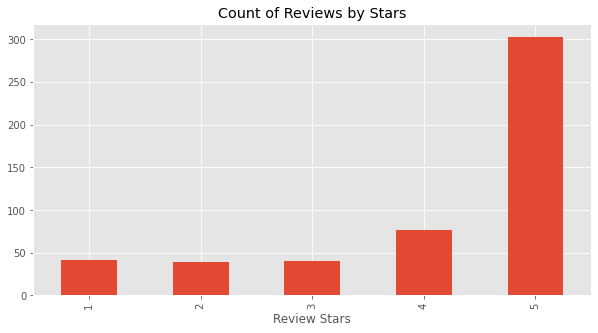

In [24]:
ax = count_score.plot(kind='bar', title='Count of Reviews by Stars', figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

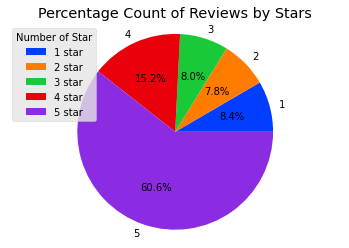

In [22]:
plt.pie(count_score, labels = ['1','2','3','4','5'], colors = sns.color_palette('bright')[0:], autopct='%1.1f%%', radius = 2)
plt.title('Percentage Count of Reviews by Stars')
plt.legend(loc = 'upper left', labels = ['1 star','2 star','3 star','4 star','5 star'], title = 'Number of Star')
plt.axis('equal')
plt.show()

# VADER Seniment Scoring

We will use NLTK's `SentimentIntensityAnalyzer` to get the neg/neu/pos scores of the text.

- This uses a "bag of words" approach:
    1. Stop words are removed
    2. each word is scored and combined to a total score.

In [8]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [53]:
sia.polarity_scores("That's hilarious")

{'neg': 0.0, 'neu': 0.27, 'pos': 0.73, 'compound': 0.4019}

In [52]:
sia.polarity_scores('This is the worst pre-trained model ever =))')

{'neg': 0.369, 'neu': 0.631, 'pos': 0.0, 'compound': -0.6249}

In [27]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['review_body']
    myid = i
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [37]:
df = df.reset_index().rename(columns={'index':'Id'})
# I add ID column by using index of Dataframe to merge with vaders have common column ID

vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how = 'left')

In [39]:
# Now we have sentiment score and metadata
vaders.head()

,Id,neg,neu,pos,compound,star_rating,review_body
0,0,0.000,0.597,0.403,0.9665,5,so beautiful even tho clearly not high end ......
1,1,0.112,0.794,0.094,0.1625,5,"Great product.. I got this set for my mother, ..."
2,2,0.000,0.638,0.362,0.9347,5,Exactly as pictured and my daughter's friend l...
3,3,0.000,0.402,0.598,0.9656,5,Love it. Fits great. Super comfortable and nea...
4,4,0.000,0.554,0.446,0.9167,5,Got this as a Mother's Day gift for my Mom and...


# Roberta Pretrained Model

- Use a model trained of a large corpus of data.
- Transformer model accounts for the words but also the context related to other words.

In [ ]:
!pip install transformers

In [12]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [42]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [46]:
# Run for Roberta Model
encoded_text = tokenizer('I drink my favorite beverage', return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.0015882059, 'roberta_neu': 0.04920696, 'roberta_pos': 0.9492048}


In [44]:
def polarity_scores_roberta(text_sample):
    encoded_text = tokenizer(text_sample, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [47]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['review_body']
        myid = i
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

In [48]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

## Compare Scores between models

In [50]:
results_df

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,star_rating,review_body
0,0,0.000,0.597,0.403,0.9665,0.002334,0.010713,0.986953,5,so beautiful even tho clearly not high end ......
1,1,0.112,0.794,0.094,0.1625,0.016511,0.092473,0.891015,5,"Great product.. I got this set for my mother, ..."
2,2,0.000,0.638,0.362,0.9347,0.002375,0.010621,0.987004,5,Exactly as pictured and my daughter's friend l...
3,3,0.000,0.402,0.598,0.9656,0.001267,0.008212,0.990521,5,Love it. Fits great. Super comfortable and nea...
4,4,0.000,0.554,0.446,0.9167,0.001195,0.007583,0.991222,5,Got this as a Mother's Day gift for my Mom and...
...,...,...,...,...,...,...,...,...,...,...
495,495,0.000,0.541,0.459,0.9272,0.001900,0.017036,0.981064,5,Beautiful piece! Love the fact that it looks l...
496,496,0.077,0.865,0.058,-0.3167,0.148461,0.514833,0.336706,4,My only complaint is that one of the beads fee...
497,497,0.000,0.848,0.152,0.3612,0.017673,0.872967,0.109359,4,I have a new visa card I would like to put it ...
498,498,0.000,0.728,0.272,0.7964,0.045561,0.159957,0.794482,2,I love the concept. I guess I expected better ...


# Comparing visualization

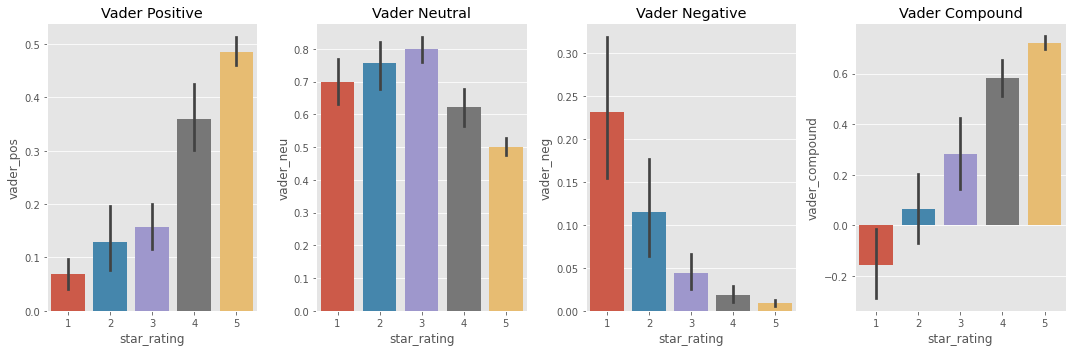

In [115]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
sns.barplot(data=results_df, x='star_rating', y='vader_pos', ax=axs[0])
sns.barplot(data=results_df, x='star_rating', y='vader_neu', ax=axs[1])
sns.barplot(data=results_df, x='star_rating', y='vader_neg', ax=axs[2])
sns.barplot(data=results_df, x='star_rating', y='vader_compound', ax=axs[3])
axs[0].set_title('Vader Positive')
axs[1].set_title('Vader Neutral')
axs[2].set_title('Vader Negative')
axs[3].set_title('Vader Compound')
plt.tight_layout()
plt.show()

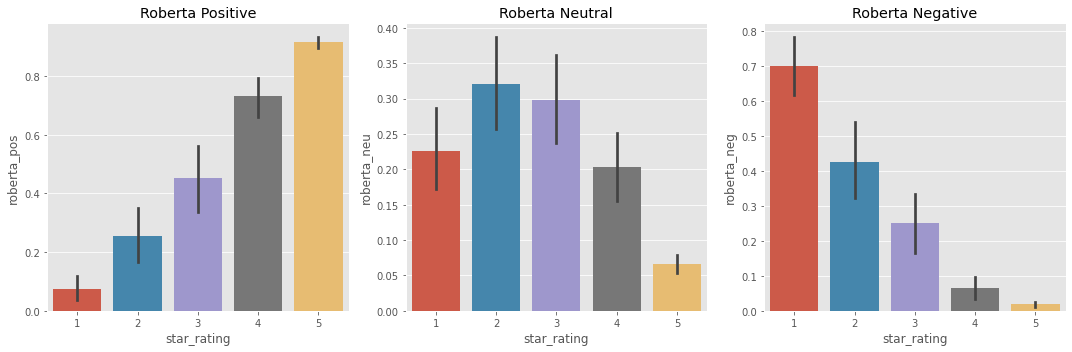

In [116]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(data=results_df, x='star_rating', y='roberta_pos', ax=axs[0])
sns.barplot(data=results_df, x='star_rating', y='roberta_neu', ax=axs[1])
sns.barplot(data=results_df, x='star_rating', y='roberta_neg', ax=axs[2])
axs[0].set_title('Roberta Positive')
axs[1].set_title('Roberta Neutral')
axs[2].set_title('Roberta Negative')
plt.tight_layout()
plt.show()

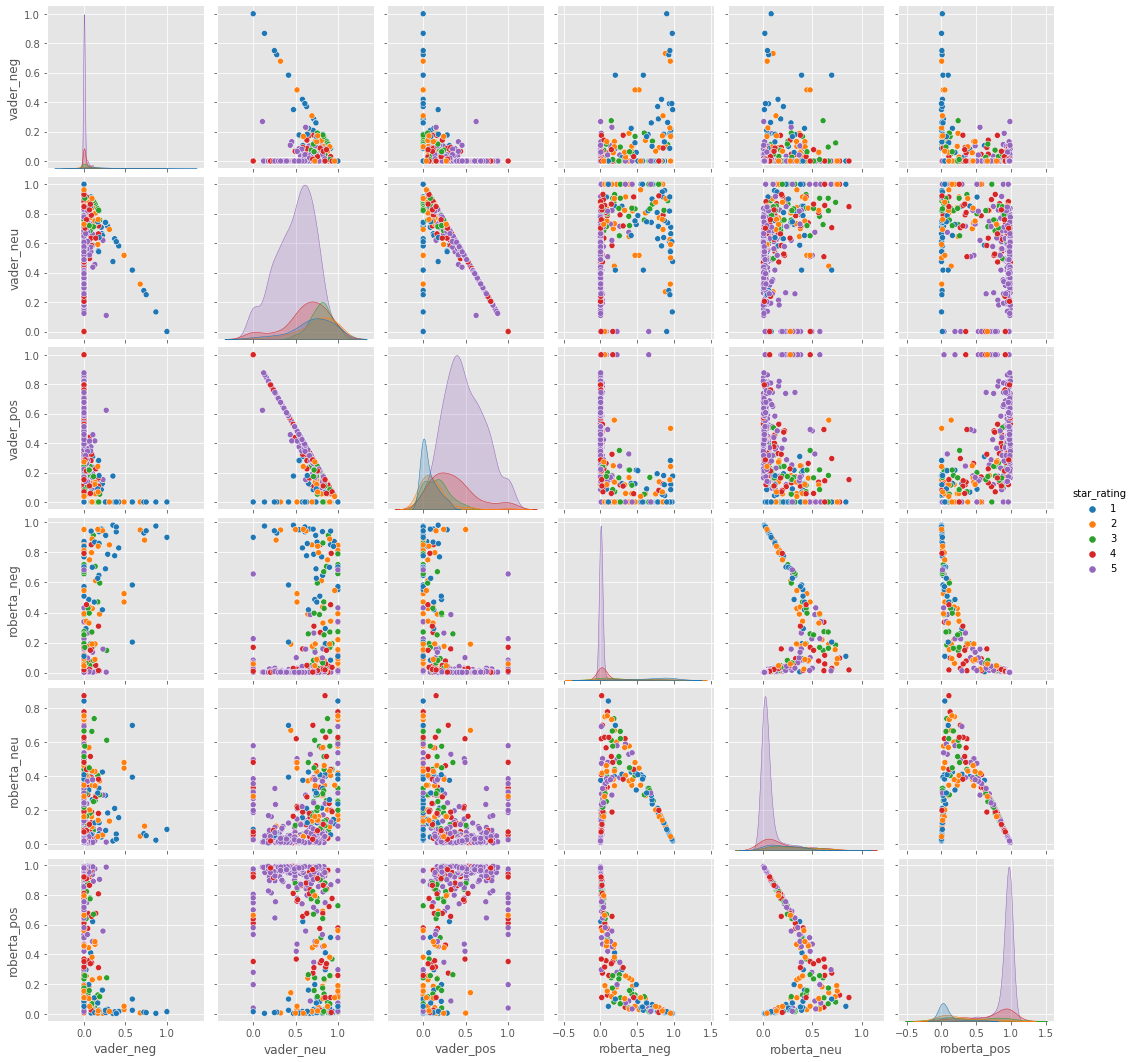

In [143]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='star_rating',
            palette='tab10')
plt.show()

# Review Examples

Lets look at some examples where the model scoring and review score differ the most.

In [138]:
results_df.query('star_rating == 1') \
    .sort_values('roberta_pos', ascending=False)['review_body'].values[0]

'It is a gift for Sept 2.  I hope it fits her bracelet.  Not sure yet.'

In [140]:
results_df.query('star_rating == 1') \
    .sort_values('vader_pos', ascending=False)['review_body'].values[0]

'It is a gift for Sept 2.  I hope it fits her bracelet.  Not sure yet.'

In [141]:
results_df.query('star_rating == 5') \
    .sort_values('roberta_neg', ascending=False)['review_body'].values[0]

'Necklace was way to small.'

In [142]:
results_df.query('star_rating == 5') \
    .sort_values('vader_neg', ascending=False)['review_body'].values[0]

'Great! Looks good. Awesome price. No complaints.'

# Extra: The Transformers Pipeline
- Quick & easy way to run sentiment predictions

In [97]:
from transformers import pipeline

tfm_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [96]:
tfm_pipeline('I love sentiment analysis!')

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [131]:
transformer_pipeline = tfm_pipeline(list(df['review_body']))

In [132]:
tfm_pipeline_df = pd.DataFrame(transformer_pipeline)

In [133]:
tfm_pipeline_df

,label,score
0,POSITIVE,0.999627
1,POSITIVE,0.991643
2,POSITIVE,0.999720
3,POSITIVE,0.999884
4,POSITIVE,0.999885
...,...,...
495,POSITIVE,0.999878
496,POSITIVE,0.531685
497,NEGATIVE,0.886866
498,NEGATIVE,0.958053


In [134]:
tfm_pipeline_df['label'].value_counts()

POSITIVE    383
NEGATIVE    117
Name: label, dtype: int64

# The End